# Simulated Annealing Example: Nurse scheduling problem

This code does a quick and dirty implementation (globals everywhere... oof) of simulated annealing to solve a simple nurse scheduling problem. It was written as an example for my blog. If you are going to actually implement it, I'd write some proper classes to handle the data. 

In [8]:
%matplotlib inline

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

from functools import partial

## Define parameters

Let's define some parameters. 
- We'll have 10 nurses and build a schedule for 10 weeks.
- Each nurse has a preference for how many days he prefers to work per week. We generate this uniformly (but you don't have to). 
- Each nurse has a per shift cost. We generate this uniformly (but you don't have to)

In a more complex implementation, I had contracted number of days per month and preferred length, i.e. how many days in a row the nurse would like to work, as different objectives. I also had multiple 'wards' within the hospital and a loss component that makes sure same person isn't working in different wards at the same time. 

You can take this scaffolding and make it as complex as you like.

In [10]:
num_nurses = 10
num_weeks = 10
preferred_len = np.random.randint(1, 6, 10)
cost = np.random.randint(1, 7, 10)

We also want to make sure that they are being equally staffed.

In [11]:
total_len = preferred_len.sum()
preferred_len_prob = [x/total_len for x in preferred_len]

Define *Week* class ('namedtuple' FTW). 

In [12]:
days_of_week = ['m','tu','w','th','f','sa','su']
Weektuple = namedtuple('week', days_of_week)

class Week(Weektuple):
    def days_works(self, n):
        ''' Returns the number days worked by nurse n'''
        return sum([x==n for x in self])
    

Define a *schedule* as a list of *weeks*

In [13]:
schedule = [Week(**dict(zip(days_of_week, np.random.randint(0,10,10)))) for w in range(num_weeks)]

## Define functions

### The loss function

We define loss as being the sum of two (three) things:
- len_loss: the loss from not meeting the nurse's preferred length
- shift_loss: the loss from not scheduling everyone evenly as per their preferred length
- (optional) staffing_cost: the total cost of the schedule

I commented out staffing_cost because I wanted to see how it balanced the other two. With it on, it put the cheaper ones on more and I have trouble visually verifying that the other criteria were being satisfied.

You may want to weight the different things differently. The *weights* mapping, lets you do that.

In [24]:
def loss_func(schedule, weights = None):
    l1 = sum([len_loss(w) for w in schedule])
    #l2 = staffing_cost(schedule)
    l3 = shift_loss(schedule)
    
    if weights is None:
        weights = {'l1':1, 'l2':1, 'l3':1}
        
    return weights['l1'] * l1 + weights['l3']*l3

We are only looking the *difference* between the preferred days and days worked. You could set it up as a percentage. So getting a 6 days shift if you prefer 7 is not as bad as getting a 2 day shift when you prefer 1.

In [15]:
def len_loss(w):
    loss = 0
    
    for n in range(num_nurses):
        n_work_days = w.days_works(n)
        if w.days_works(n) > 0:
            loss += np.abs(n_work_days - preferred_len[n])
    
    return loss

In [16]:
def staffing_cost(schedule):
    return sum([staffing_cost_week(w) for w in schedule])

def staffing_cost_week(week):
    return sum([cost[n] * week.days_works(n) for n in range(num_nurses)])

The share of shifts must be close to the share based on preferred lengths

In [17]:
def shift_loss(schedule):
    
    total_shifts = np.zeros(num_nurses)
    
    for w in schedule:
        for n in range(num_nurses):
            total_shifts[n] = w.days_works(n)
    
    total_shifts = total_shifts / total_shifts.sum()
    
    return 2 * num_nurses * num_weeks * np.abs(preferred_len_prob - total_shifts).sum()

### The proposal function

The proposal function is pretty easy. Change "perc_flip" percent of weeks in the schedue. For each of those works, increment "per_flip" random nurse id. 

Note that this has the property that all states are *communicable* (all combinations of staffing is possible) and the chain has *detailed balance*. You can easily reverse the change, just reduce nurse id by 1.

In [18]:
def proposal(schedule, perc_flip = 0.5, per_flip = 2):
    weeks_to_flip = [ x for x in range(len(schedule)) if (np.random.random() > perc_flip) ]
    #print(weeks_to_flip)
    
    new_schedule = schedule.copy()
    
    for w in weeks_to_flip:
        new_schedule[w] = increment(new_schedule[w], per_flip)
    
    return new_schedule

def increment(w, num = 2):
    
    new_w = w._asdict()
    
    for i in range(num):
        day = days_of_week[np.random.randint(0, 7)]

        if new_w[day] == (num_nurses - 1): new_w[day] = 0
        else: new_w[day] += 1
    
    return Week(**new_w)

### The simulated annealing function

This is the workhorse that actually does the annealing. A lot of this code is borrowed from AM207 (Rahul Dave and team) but it's pretty standard stuff - I just didn't want to have to write it.

In [20]:
def sim_anneal(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    """
    Run simulated annealing.
    """

    accumulator=[]
    
    # Our initial state is in initials['solution']
    best_solution = old_solution = initials['solution']
    
    # Our initial temperature is in initials['T']
    T=initials['T']
    
    # Our initial length (i.e. number of iterations per epoch)
    # is in initals['length']
    length=initials['length']
    
    # initialize the energy of our current state by running the 
    # energy function on our initial solution
    best_energy = old_energy = energyfunc(old_solution)
    
    # keep track of accepted proposals and total iterations
    accepted=0
    total=0
    
    for index in range(epochs):

        # if we're past the first index, we need
        # to update our cooling schedule and iteration
        # schedule
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
        
        if not index % 5:
            print("EPOCH", index, ": Temperature %0.2f" % T, "Length", length, 'Loss %0.2f' % best_energy)
        
        # run through the iterations for each epoch
        for it in range(length):
            
            # keep track of total proposals
            total+=1
            
            # get a new proposal and calculate its energy
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                
                # Accept proposed solution
                accepted += 1.0
                accumulator.append({'epoch':index, 'T':T, 'schedule':new_solution, 
                                    'loss':new_energy, 'iteration':total})
                
                # we have a new candidate for optimum (minimum)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                    
                old_energy = new_energy
                old_solution = new_solution
                
            else:
                # Keep track of old solution if we don't accept the new one
                accumulator.append({'epoch':index, 'T':T, 'schedule':old_solution, 
                                    'loss':old_energy, 'iteration':total})
                
    # Print some results
    print("------")
    print("\nFrac accepted : ", accepted/total, "\nTotal iterations : ", total, "\nSolution :", old_solution)
    print("Final Energy :", best_energy, "Final length :", length)
    
    return best_energy, best_solution, accumulator

### Plot the results

This function just draws a heatmap that helps to visualize the final schedule.

In [21]:
def plot_schedule(schedule):
    all_data = {}
    for i, w in enumerate(bs):
        all_data['week' + str(i)] = w._asdict()
    
    df = pd.DataFrame(all_data)
    df = df.loc[days_of_week,:].T
    
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    ax = sns.heatmap(df, cmap="Set1", linewidths=1, square=True, ax = ax)
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.linspace(0.5, num_nurses - 1 + 0.5, num_nurses ))
    cbar.set_ticklabels(np.linspace(0.5, num_nurses - 1 + 0.5, num_nurses ) - 0.5)

    return df

## Results

Try playing around with *perc_flip* and *per_flip*. Now that I think about it, these are terribly named. Sorry - doing this late at night makes for bad variable name choices.

In [25]:
prop_part = partial(proposal, perc_flip = 0.5, per_flip = 3)

Set initials and run it!

In [26]:
initials = {}
initials['T'] = 5000
initials['solution'] = schedule
initials['length'] = 7

epochs = 90

tempfunc = lambda t: t * 0.9
lengthfunc = lambda l : int(np.ceil(l * 1.1))


be, bs, acc = sim_anneal(loss_func, initials, epochs, tempfunc, lengthfunc, prop_part)

EPOCH 0 : Temperature 5000.00 Length 7 Loss 324.89
EPOCH 5 : Temperature 2952.45 Length 13 Loss 186.10
EPOCH 10 : Temperature 1743.39 Length 24 Loss 186.10
EPOCH 15 : Temperature 1029.46 Length 41 Loss 186.10
EPOCH 20 : Temperature 607.88 Length 70 Loss 178.63
EPOCH 25 : Temperature 358.95 Length 115 Loss 178.63
EPOCH 30 : Temperature 211.96 Length 188 Loss 178.63
EPOCH 35 : Temperature 125.16 Length 305 Loss 171.63
EPOCH 40 : Temperature 73.90 Length 494 Loss 171.63
EPOCH 45 : Temperature 43.64 Length 798 Loss 156.10
EPOCH 50 : Temperature 25.77 Length 1287 Loss 151.10
EPOCH 55 : Temperature 15.22 Length 2075 Loss 151.10
EPOCH 60 : Temperature 8.99 Length 3346 Loss 140.10
EPOCH 65 : Temperature 5.31 Length 5392 Loss 132.10
EPOCH 70 : Temperature 3.13 Length 8687 Loss 129.10
EPOCH 75 : Temperature 1.85 Length 13994 Loss 116.10
EPOCH 80 : Temperature 1.09 Length 22541 Loss 102.10
EPOCH 85 : Temperature 0.65 Length 36306 Loss 89.10
------

Frac accepted :  0.06363939785535178 
Total iter

Let's see what our loss looks like

In [27]:
acc_df = pd.DataFrame(acc)

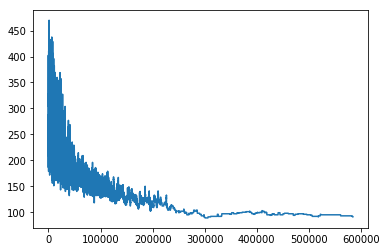

In [28]:
plt.plot(acc_df.loss)

Ok cool. Looks like we do get to a steady state towards the end. 
Play around with changing the initial temp, tempfunc, and lengthfunc and see if you can improve it. Here's the best solution and the best loss

In [29]:
bs, be

([Week(m=3, tu=3, w=3, th=3, f=1, sa=8, su=3),
  Week(m=5, tu=5, w=9, th=5, f=9, sa=1, su=8),
  Week(m=9, tu=2, w=1, th=9, f=2, sa=9, su=2),
  Week(m=1, tu=5, w=5, th=8, f=5, sa=5, su=5),
  Week(m=8, tu=3, w=5, th=5, f=3, sa=3, su=3),
  Week(m=5, tu=2, w=5, th=7, f=7, sa=5, su=2),
  Week(m=6, tu=7, w=7, th=8, f=6, sa=6, su=6),
  Week(m=1, tu=3, w=3, th=7, f=3, sa=3, su=3),
  Week(m=2, tu=6, w=6, th=6, f=2, sa=2, su=2),
  Week(m=2, tu=3, w=6, th=0, f=9, sa=5, su=4)],
 89.100840336134468)

Let's visualize the schedule

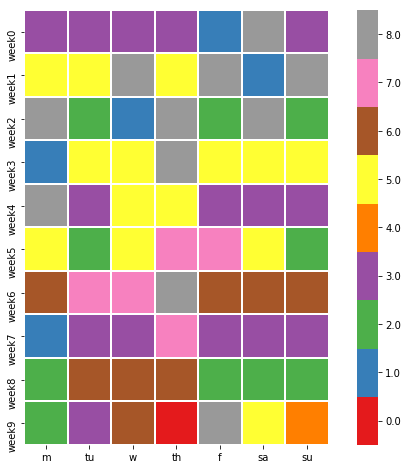

In [30]:
_ = plot_schedule(bs)

## Discussion 

Check out the *preferred_length* and *staff cost* (if you used it) and see if the results make sense. For one, why does '0' just get one shift? Same with '4'? Might be that someone has to miss out given the contraints. Maybe the loss from shift_loss should be quadratic - further away you are from optimum, greater the loss.

In [37]:
print("Preferred_length:\t", dict(zip(range(10), preferred_len)))

Preferred_length	 {0: 4, 1: 1, 2: 4, 3: 5, 4: 5, 5: 5, 6: 4, 7: 2, 8: 1, 9: 3}


In [38]:
print("Staff_cost:\t\t", dict(zip(range(10), cost)))

Staff_cost:		 {0: 1, 1: 6, 2: 5, 3: 5, 4: 1, 5: 6, 6: 4, 7: 5, 8: 5, 9: 1}


- Can you figure out ways to improve it? 
- Can that be coded in the loss function? 
- Can we use that to come up with a better proposal function?

## Conclusion

I hope this gave you a rough idea on how to use simulated annealing. If you come up with cool proposal functions or fancier loss functions, I'd love to hear about this: https://sidravi1.com/